In this notebook, we will explore a linear regression model coupled with Principal Component Analysis (PCA). The idea behind PCA is to find independent linear combinations of input features that explain most of the variance observed in the dataset. Let's start by setting up the code to load the data and split it in training and validation subsets.

In [30]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import *
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression,  Ridge, Lasso
from sklearn.gaussian_process import GaussianProcessRegressor as GPR
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
import pandas as pd
import seaborn as sns

## Get the dataset as numpy array

data = pd.read_csv('data/CDMS_Dataset.csv', sep=',')

features = list(data.columns)[1:]
x_data = data.values[:,1:-1]
y_data = data.values[:, -1]
n_features = len(features)

y_norm = -41.9 # largest y dimension to be used to normalize y data

def split_data(split_type='random', labels = []):
    if split_type == 'random':
        X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.20, random_state=42)
    if split_type == 'label':
        X_train = data.loc[~data[features[-1]].isin(labels)].values[:, 1:-1]
        X_test = data.loc[data[features[-1]].isin(labels)].values[:, 1:-1]
        y_train =  data.loc[~data[features[-1]].isin(labels)].values[:, -1]
        y_test = data.loc[data[features[-1]].isin(labels)].values[:, -1]    
    
    
    x_mean = np.mean(X_train, axis = 0)
    x_std  = np.std(X_train, axis = 0)
    X_train = (X_train - x_mean)/x_std
    X_test  = (X_test - x_mean)/x_std
    y_train = y_train/y_norm
    y_test  = y_test/y_norm
    
    return X_train, X_test, y_train, y_test, x_mean, x_std

In [31]:
class CDMS_PCA:
    def __init__(self, X_train, y_train, X_test, y_test, x_mean, x_std, n_components):
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        self.x_mean = x_mean
        self.x_std = x_std
        self.pca = PCA(n_components = n_components)
        self.pca.fit(self.X_train)
        # print("Number of principal components chosen = {}".format(self.pca.n_components_))
    
    def get_components(self):
        return self.pca.components_
    
    def get_ncomponents(self):
        return self.pca.n_components_
    
    def get_variances(self):
        return self.pca.explained_variance_
    
    def get_variance_ratios(self):
        return self.pca.explained_variance_ratio_
    
    def transform(self, X):
        return self.pca.transform(X)
    
    def do_LR(self, do_plot=True, mode='LR', alpha=1.0):
        print("Performing Linear regression using principal components and evaluating with test data")
        X_train_pc = self.pca.transform(self.X_train)
        X_test_pc = self.pca.transform(self.X_test)
        y_train = self.y_train
        y_test = self.y_test
        if mode == 'LR':
            LR_PCA = LinearRegression().fit(X_train_pc, y_train)
        if mode == 'Ridge':
            LR_PCA = Ridge(alpha=alpha).fit(X_train_pc, y_train)
        if mode == 'Lasso':
            LR_PCA = Lasso(alpha=alpha).fit(X_train_pc, y_train)
        
        y_train_pred_pc = LR_PCA.predict(X_train_pc)
        MSE_train = np.sqrt(np.mean((y_train*y_norm - y_train_pred_pc*y_norm)**2))
        
        y_test_pred_pc = LR_PCA.predict(X_test_pc)
        MSE_test = np.sqrt(np.mean((y_test*y_norm - y_test_pred_pc*y_norm)**2))
        
        print("RMSE from train data = {}".format(MSE_train))
        print("RMSE from test data = {}".format(MSE_test))
        
        fig = plt.figure(figsize=(8,8))
        plt.scatter(y_train*y_norm, y_train_pred_pc*y_norm, marker='x', s=100, color='b', label='Train')
        plt.scatter(y_test*y_norm,  y_test_pred_pc*y_norm, marker='.', color='r', label='Test')
        plt.plot(y_train*y_norm, y_train*y_norm, color='k')
        plt.xlabel("True Value")
        plt.ylabel("Predicted Value")
        plt.legend(fontsize = 20)
        plt.show()
        

Now we can quickly check how the transformed variables are correlated among themselves.

<AxesSubplot:>

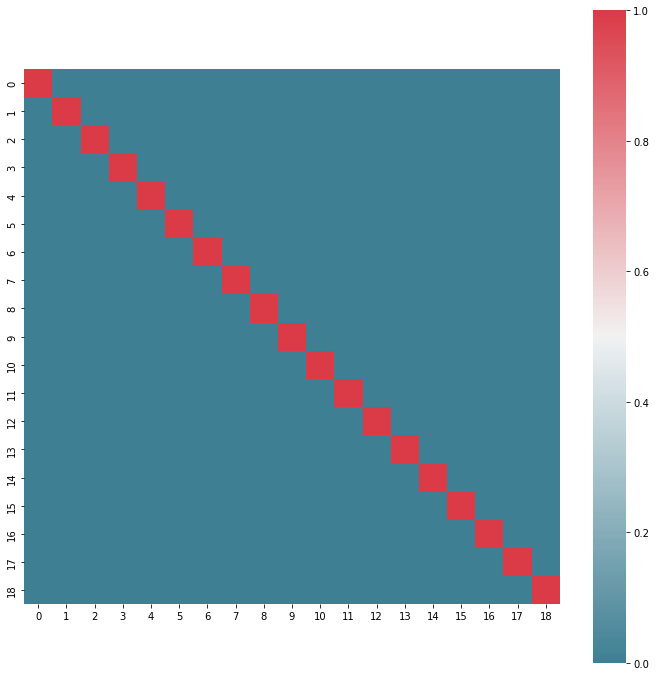

In [32]:
X_train, X_test, y_train, y_test, x_mean, x_std = split_data(split_type='label', 
                                                             labels = [-12.502, -29.5, -41.9])
pca =  CDMS_PCA(X_train, y_train, X_test, y_test, x_mean, x_std, n_components=0.99999)
x_train_trans = pca.transform(X_train)
x_corr = np.corrcoef(x_train_trans, rowvar=False)
f, ax = plt.subplots(figsize=(12,12))
sns.heatmap(x_corr, mask=np.zeros_like(x_corr, dtype=bool),
            cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

As we can see, the transformed feature space are all pairwise orthogonal, with each off-diagonal element of the correlation matrix being exactly 0. Next, we can check which principal compoent is responsible for what fraction of the observed variances in the feature space.

In [33]:
pca.get_variance_ratios()

array([5.05128722e-01, 2.67507772e-01, 6.67132035e-02, 5.33815372e-02,
       2.67580815e-02, 1.84862620e-02, 1.49671856e-02, 1.16672904e-02,
       7.66419373e-03, 7.34345748e-03, 6.11804577e-03, 3.69023259e-03,
       2.85607687e-03, 2.57514600e-03, 2.29098976e-03, 1.19477517e-03,
       9.86252290e-04, 5.26473764e-04, 1.44302296e-04])

The first principal component alone explains 50% of the variance observed in the feature space, while the last principal component explains only about 0.014% of the variance. Now, we can keep a first few of these and perform a linear regression to see how well it performs. We will choose to keep the components that contribute a total of 90% of the observed variances.

Number of components chosen:  5
Performing Linear regression using principal components and evaluating with test data
RMSE from train data = 2.3592727000003473
RMSE from test data = 2.6011879164841782


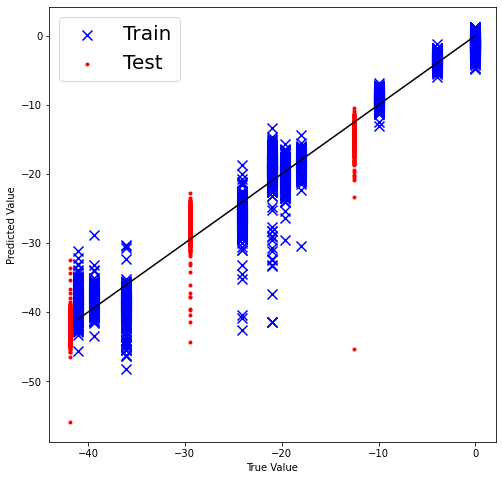

In [59]:
pca =  CDMS_PCA(X_train, y_train, X_test, y_test, x_mean, x_std, n_components=0.9)
print("Number of components chosen: ", pca.get_ncomponents())
pca.do_LR()

I think at this point it can be a great exercise for the students to use the code given in this notebook to develop the model in FAIR way. One can use the previous notebooks on linear regression to see how the directory hierarchy has been built, the code has been organized, and eventually the model has been published.